# Basic setting

In [10]:
import os
import sys
import pandas as pd
# options for display setting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False) 
import numpy as np
import dbfread
from dbfread import DBF
import dbf
from glob import glob 
from sklearn.preprocessing import OneHotEncoder


## check 
import datetime 
from datetime import datetime
import time


import csv
import pickle

from scipy.interpolate import interp1d
import scipy.stats as stats

import dbfread
from dbfread import DBF
import dbf
from glob import glob 

from collections import Counter
from tqdm import tqdm
import plotly.express as px


import matplotlib.pyplot as plt

import plotly as py
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


pd.options.mode.chained_assignment = None

import utils
from utils.model_utils import eda_mean, eda_count_peaks, eeg_mean_bandpower, temp_mean, signal_interp, label_bin, acc_mag_mean, ecg_hrv, ecg_hr, aggregate_audio


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

from sklearn.model_selection import train_test_split


# Data Load

Once you load data, following feature extraction is required. 
Because it requires some time to extract features according to the environments, please use a code to save the extracted features once you decide your windows for feature extraction. 
Ours are extracted based on the basic settings below. 


In [2]:
# DATASET = '/Users/iduli/Desktop/Ch2_25_Scientific_Data/DATASET/EmoWorker' # change the dataset link
DATASET = '../K-EmoWorker'

LABELS = os.path.join(DATASET, 'LABELS')
label = os.path.join(LABELS, 'label.pkl')
with open(label, 'rb') as f:
  LABELS = pickle.load(f)

SENSOR_PATH = os.path.join(DATASET, 'SENSORS')
sensors = os.path.join(SENSOR_PATH, 'sensors.pkl')
with open(sensors, 'rb') as f:
  SENSORS = pickle.load(f)

audio = os.path.join(SENSOR_PATH, 'audio.pkl')
with open(audio, 'rb') as f:
  AUDIO = pickle.load(f)

META = os.path.join(DATASET, 'META')
general_information = 'meta.csv'
meta = pd.read_csv(os.path.join(META, general_information), index_col=None)
video = os.path.join(SENSOR_PATH, 'video.pkl')
with open(video, 'rb') as f:
  VIDEO = pickle.load(f)


# 1. Time-sync visualization

In [3]:
variable_names = [
    "PNUM", "ECG_HRV", "ECG_HR", "EDA_MEAN", "EDA_PEAK", "TEMP_MEAN",
    "ACC_MEAN", "EEG_MEAN_BANDPOWER", "AUDIO_CUSTOMER", "AUDIO_WORKER", "LABEL"
    "VIDEO"
    ]

for name in variable_names:
    globals()[name] = pd.DataFrame()

eeg_sampling_rate = 256

#selected_labels = LABELS.items() # All
selected_labels = dict(list(LABELS.items())[:3]) # Visualize three users' data

pnum: 1 session: c1


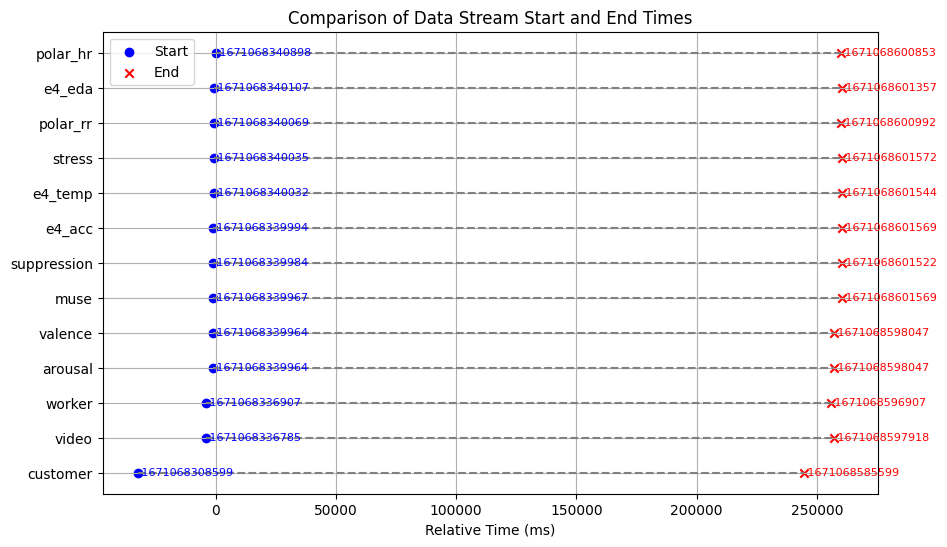

pnum: 1 session: c2


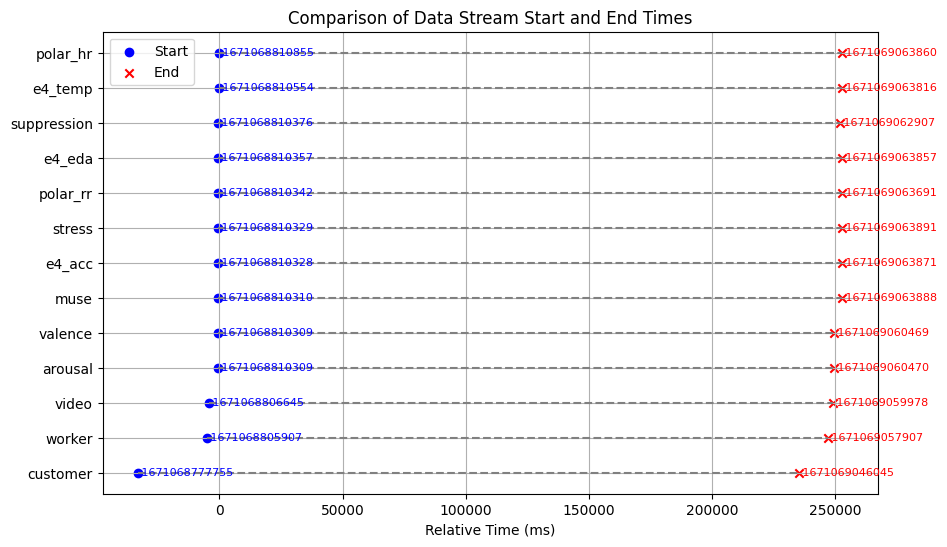

pnum: 1 session: c3


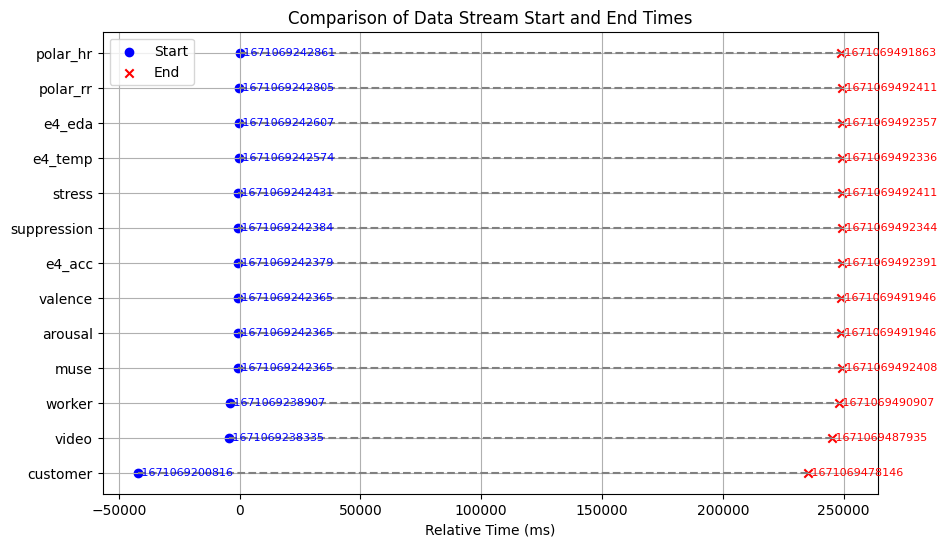

pnum: 2 session: c1


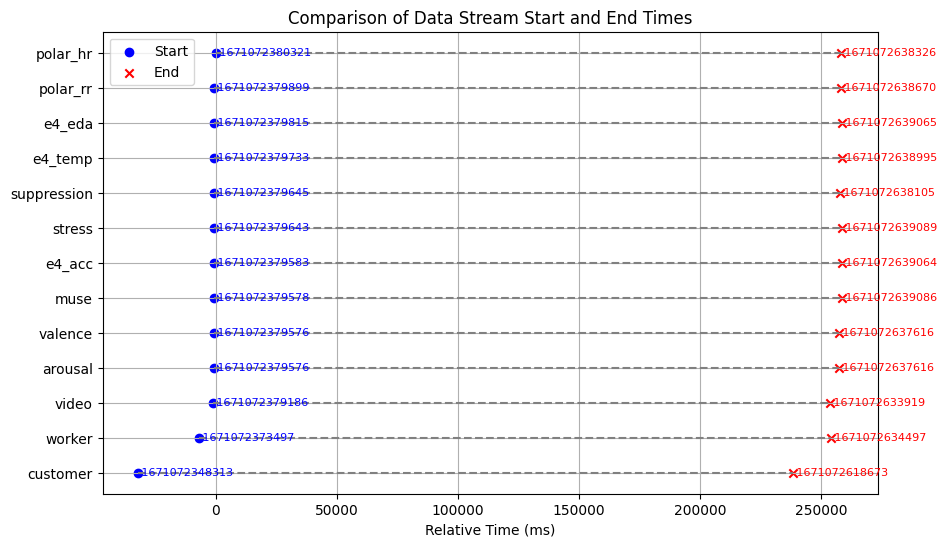

pnum: 2 session: c2


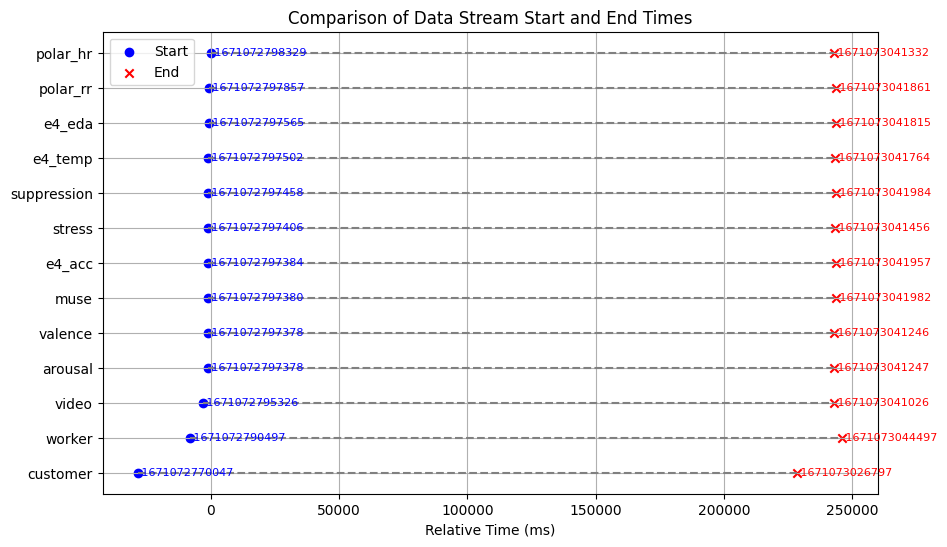

pnum: 2 session: c3


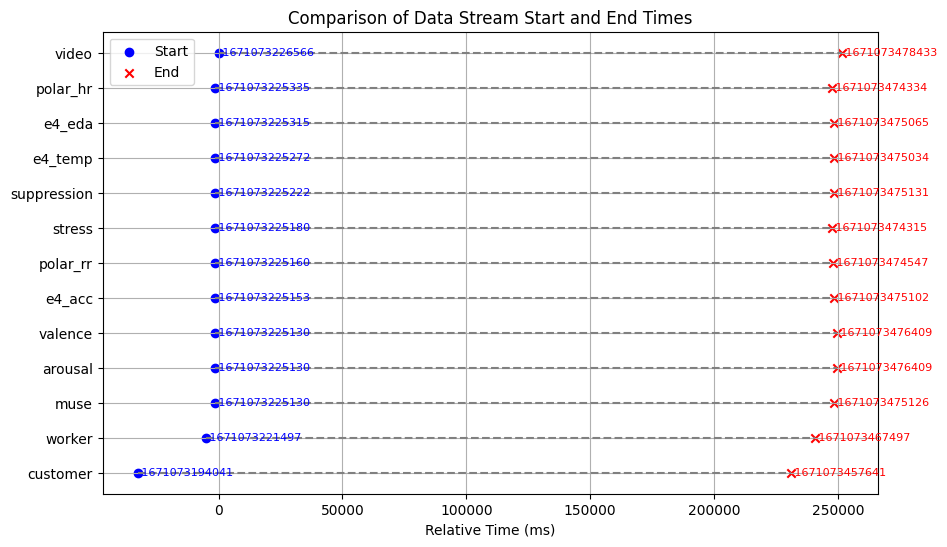

pnum: 3 session: c1


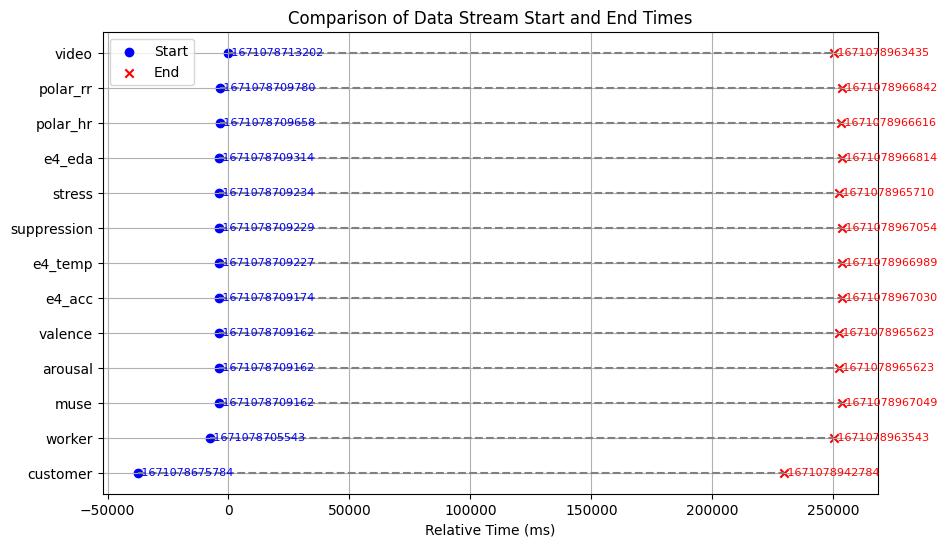

pnum: 3 session: c2


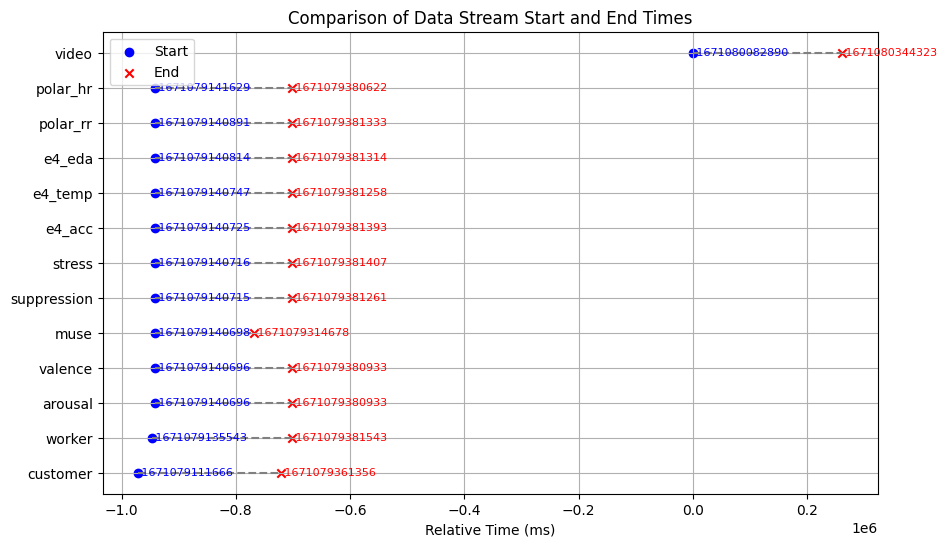

pnum: 3 session: c3


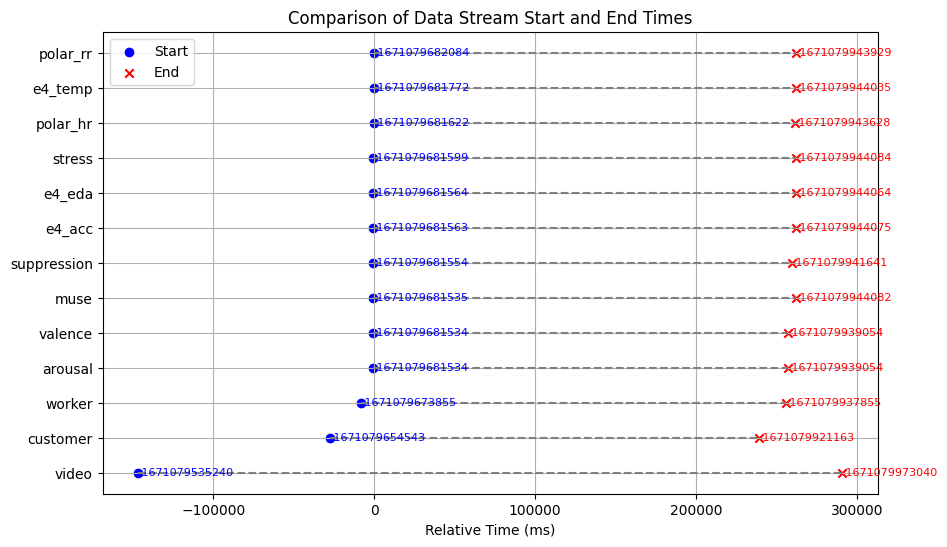

In [4]:
for i, sessions in selected_labels.items():
    order_type = meta.loc[meta["Pnum"] == i, "order_type"].values[0]
    c1, c2, c3 = 0, (1 if order_type == 1 else 2), (2 if order_type == 1 else 1)
       
    for session in sessions.keys():
        print('pnum:', i, 'session:', session) 
        '''Load data'''
        sensor_keys = ['e4_eda', 'e4_temp', 'e4_acc', 'polar_rr', 'polar_hr', 'muse']
        sensor_data = {key: pd.DataFrame(SENSORS[i][session][key]) for key in sensor_keys}
        label_keys = ['stress', 'arousal', 'valence', 'suppression']
        label_data = {key: pd.DataFrame(LABELS[i][session][key]) for key in label_keys}

        video_data = VIDEO[i][session] 
        
        audio_keys = {1: 'worker', 2: 'customer'}
        audio_data = {
            audio_keys[key]: pd.DataFrame(AUDIO[i][session][key]).rename(columns=lambda x: f"{audio_keys[key]}_{x}" if x != 'Timestamp' else x)
            for key in audio_keys
            }        
        '''preprocessing '''
        # MUSE_interpolation 
        sensor_data['muse'] = signal_interp(sensor_data['muse'], eeg_sampling_rate)

        '''Data crop'''
        # Check timestamps
        timestamps = {}
        for key, df in {**sensor_data, **label_data, **audio_data, "video": video_data}.items():
            #print(key)
            #ts_list = df['Timestamp'].tolist() 
            if isinstance(df, pd.DataFrame):
                ts_list = df['Timestamp'].tolist() if 'Timestamp' in df.columns else []
            elif isinstance(df, pd.Series):
                ts_list = df.tolist() if df.name == 'Timestamp' else []
            else:
                ts_list = []
            if ts_list:
                timestamps[key] = ts_list
                #print(f"[{key}] t0 = {ts_list[0]}, t-1 = {ts_list[-1]}, Δ = {ts_list[-1] - ts_list[0]} ms")
            else:
                print(f"[{key}] ⚠️ Timestamp list is empty.")

        # extract start_times (t0) and end_times (t_last)
        start_times = {key: ts[0] for key, ts in timestamps.items() if ts}
        end_times = {key: ts[-1] for key, ts in timestamps.items() if ts}

        # find max and min time to calculate relative time
        max_start = max(start_times.values())
        min_end = min(end_times.values())

        # relative start and end times (unit: ms)
        relative_start_times = {key: st - max_start for key, st in start_times.items()}
        relative_end_times = {key: et - max_start for key, et in end_times.items()}

        # Sort for the order to be output on the y-axis
        sorted_keys = sorted(relative_start_times, key=relative_start_times.get)
        sorted_start_vals = [relative_start_times[key] for key in sorted_keys]
        sorted_end_vals = [relative_end_times[key] for key in sorted_keys]

        # visualization
        plt.figure(figsize=(10, 6))

        # start point: blue 'o' (circle)
        plt.scatter(sorted_start_vals, range(len(sorted_keys)), color='blue', marker='o', label='Start')
        # end point: red 'x'
        plt.scatter(sorted_end_vals, range(len(sorted_keys)), color='red', marker='x', label='End')

        # dashed line to connect start and end points
        for p in range(len(sorted_keys)):
            plt.plot([sorted_start_vals[p], sorted_end_vals[p]], [p, p], color='gray', linestyle='--')

        plt.yticks(range(len(sorted_keys)), sorted_keys)
        plt.xlabel("Relative Time (ms)")
        plt.title("Comparison of Data Stream Start and End Times")
        plt.grid(True)
        plt.legend()

        # Add timestamp annotations for each point
        for p, key in enumerate(sorted_keys):
            plt.text(sorted_start_vals[p], p, f" {start_times[key]:.0f}", va='center', fontsize=8, color='blue')
            plt.text(sorted_end_vals[p], p, f" {end_times[key]:.0f}", va='center', fontsize=8, color='red')

        plt.show()

# 2. Technical validation using ML

## A. Data preprocessiong
* data crop 
* apply filter, interpolation  
* feature extraction 
* transform data and build initial dataset in a form of Dataframe for integration 
* This codes only use E4, Polar H10, Muse S, Audio data. 

### - Features extraction 

In [5]:
# setting for feature extraction, users can change this 
physi_window = 10
audio_window = 5
acc_window = 5
label_window = 5
slide = 1

eeg_sampling_rate = 256

In [6]:
from IPython.display import display, clear_output

log_df = pd.DataFrame(columns=["pnum", "session", "EDA length", "EEG length", "TEMP length", "ACC length",
                               "ECG_HRV length", "ECG_HR length", "AUDIO customer length", "AUDIO worker length", "LABEL length",
                               "Global time (max)", "Global time (min)", "duration"])

variable_names = [
    "PNUM", "ECG_HRV", "ECG_HR", "EDA_MEAN", "EDA_PEAK", "TEMP_MEAN",
    "ACC_MEAN", "EEG_MEAN_BANDPOWER", "AUDIO_CUSTOMER", "AUDIO_WORKER", "LABEL"
    ] 

for name in variable_names:
    globals()[name] = pd.DataFrame()

for i, sessions in LABELS.items():
    order_type = meta.loc[meta["Pnum"] == i, "order_type"].values[0]
    c1, c2, c3 = 0, (1 if order_type == 1 else 2), (2 if order_type == 1 else 1)
       
    for session in sessions.keys():
        print('pnum:', i, 'session:', session) 
        '''Load data'''
        sensor_keys = ['e4_eda', 'e4_temp', 'e4_acc', 'polar_rr', 'polar_hr', 'muse']
        sensor_data = {key: pd.DataFrame(SENSORS[i][session][key]) for key in sensor_keys}
        label_keys = ['stress', 'arousal', 'valence', 'suppression']
        label_data = {key: pd.DataFrame(LABELS[i][session][key]) for key in label_keys}

        video_data = VIDEO[i][session] 
        
        audio_keys = {1: 'worker', 2: 'customer'}
        audio_data = {
            audio_keys[key]: pd.DataFrame(AUDIO[i][session][key]).rename(columns=lambda x: f"{audio_keys[key]}_{x}" if x != 'Timestamp' else x)
            for key in audio_keys
            }        
        
        '''preprocessing '''
        # MUSE_interpolation 
        sensor_data['muse'] = signal_interp(sensor_data['muse'], eeg_sampling_rate)

        '''Data crop'''
        timestamps = {key: df['Timestamp'].tolist() for key, df in {**sensor_data, **label_data, **audio_data}.items()}
        max_start = max(t[0] for t in timestamps.values() if t)
        min_end = min(t[-1] for t in timestamps.values() if t)
        print('Global time range:', max_start, 'to', min_end, min_end - max_start)

        # Actual synchronization processing + considering all sources
        for key, df in {**sensor_data, **label_data, **audio_data}.items():
            time_col = 'Timestamp'
            # Both conditions must be included to leave only the overlapping range
            df = df.loc[(df[time_col] >= max_start) & (df[time_col] <= min_end)]                
            if key in sensor_data:
                sensor_data[key] = df
            elif key in label_data:
                label_data[key] = df
            elif key in audio_data:
                audio_data[key] = df

        #feature extraction 
        # E4    
        out_eda_mean = eda_mean(sensor_data['e4_eda'], physi_window, slide) 
        out_eda_peak = eda_count_peaks(sensor_data['e4_eda'], physi_window, slide)
        out_temp_mean = temp_mean(sensor_data['e4_temp'], physi_window, slide)
        out_acc_mag_mean = acc_mag_mean(sensor_data[ 'e4_acc'], acc_window, slide)
        # Polar H10
        out_ecg_hrv = ecg_hrv(sensor_data['polar_rr'], physi_window, slide)
        out_ecg_hr = ecg_hr(sensor_data['polar_hr'], physi_window, slide)
        # MUSE : eeg_mean_bandpower
        out_eeg_meanbp = eeg_mean_bandpower(sensor_data['muse'], sampling_rate=256, window=physi_window, slide=slide, show=False)
        # Audio 
        audio_worker_data = audio_data['worker']
        audio_customer_data = audio_data['customer']   
        out_audio_customer_mean, out_audio_customer_min, out_audio_customer_max, out_audio_customer_std = aggregate_audio(audio_customer_data, audio_window, slide)
        out_audio_worker_mean, out_audio_worker_min, out_audio_worker_max, out_audio_worker_std = aggregate_audio(audio_worker_data, audio_window, slide)

        # Labels 
        label_dfs = []
        for label_name in label_keys:
            label_df = label_bin(label_data[label_name], label_name, label_window, slide)
            label_dfs.append(label_df)
            label_df = label_df.rename(columns={'Timestamp': f'{label_name}_Timestamp'})
        label = pd.concat(label_dfs, axis=1)  # concatenate along the column axis
        label['pnum'] = i
        label['session'] = c1 if session == 'c1' else (c2 if session == 'c2' else c3)

        log_df.loc[len(log_df)] = [
            i, session,
            len(out_eda_mean), len(out_eeg_meanbp), len(out_temp_mean), len(out_acc_mag_mean),
            len(out_ecg_hrv), len(out_ecg_hr),
            len(out_audio_customer_mean), len(out_audio_worker_mean), len(label),
            max_start, min_end, min_end - max_start
        ]
        clear_output(wait=True)
        display(log_df)

        min_len = min(len(out_eda_mean), 
                    len(out_temp_mean), 
                    len(out_acc_mag_mean),
                    len(out_eeg_meanbp), 
                    len(out_ecg_hrv), 
                    len(out_ecg_hr),
                    len(out_audio_customer_mean), len(out_audio_customer_std),
                    len(out_audio_worker_mean), len(out_audio_worker_std), 
                    len(label))

        EDA_MEAN = pd.concat([EDA_MEAN, out_eda_mean.iloc[0:min_len]])
        EDA_PEAK = pd.concat([EDA_PEAK, out_eda_peak.iloc[0:min_len]])
        EEG_MEAN_BANDPOWER = pd.concat([EEG_MEAN_BANDPOWER, out_eeg_meanbp.iloc[0:min_len]])
        TEMP_MEAN = pd.concat([TEMP_MEAN, out_temp_mean.iloc[0:min_len]])
        ACC_MEAN = pd.concat([ACC_MEAN, out_acc_mag_mean.iloc[0:min_len]])
        ECG_HRV = pd.concat([ECG_HRV, out_ecg_hrv.iloc[0:min_len]])
        ECG_HR = pd.concat([ECG_HR, out_ecg_hr.iloc[0:min_len]])
        AUDIO_CUSTOMER_add = pd.concat([out_audio_customer_max.iloc[0:min_len], out_audio_customer_min.iloc[0:min_len], out_audio_customer_mean.iloc[0:min_len], out_audio_customer_std.iloc[0:min_len]], axis=1)
        AUDIO_CUSTOMER = pd.concat([AUDIO_CUSTOMER, AUDIO_CUSTOMER_add])
        AUDIO_WORKER_add = pd.concat([out_audio_worker_mean.iloc[0:min_len], out_audio_worker_min.iloc[0:min_len], out_audio_worker_max.iloc[0:min_len], out_audio_worker_std.iloc[0:min_len]], axis=1)
        AUDIO_WORKER = pd.concat([AUDIO_WORKER, AUDIO_WORKER_add])
        LABEL = pd.concat([LABEL, label.iloc[0:min_len]]) 

,pnum,session,EDA length,EEG length,TEMP length,ACC length,ECG_HRV length,ECG_HR length,AUDIO customer length,AUDIO worker length,LABEL length,Global time (max),Global time (min),duration
0,1,c1,235,235,235,240,234,234,240,240,240,1.671068e+12,1.671069e+12,244701.00000
1,1,c2,226,226,225,231,225,226,231,231,231,1.671069e+12,1.671069e+12,235190.00000
2,1,c3,226,226,226,231,225,226,231,231,231,1.671069e+12,1.671069e+12,235285.00000
3,2,c1,229,229,229,234,228,229,234,234,234,1.671072e+12,1.671073e+12,238352.00000
4,2,c2,219,219,219,224,219,219,224,224,224,1.671073e+12,1.671073e+12,228468.00000
5,2,c3,223,223,223,228,222,223,228,228,228,1.671073e+12,1.671073e+12,232306.00000
6,3,c1,223,223,223,228,223,222,229,229,228,1.671079e+12,1.671079e+12,233004.00000
7,3,c2,163,163,163,169,163,163,169,169,168,1.671079e+12,1.671079e+12,173049.46875
8,3,c3,229,229,229,235,229,229,235,235,234,1.671080e+12,1.671080e+12,239079.00000
9,4,c1,198,198,198,203,197,198,203,203,203,1.671083e+12,1.671084e+12,207962.00000


### - Label Encoding 

In [11]:
def encode_all_labels_all_conditions(df, targets):
    df_encoded = df.copy()
    for target in targets:
        dynamic_col = f"perceived_{target}"
        df_encoded[dynamic_col] = np.nan
        
        for pnum, indices in df_encoded.groupby('pnum').groups.items():
            group = df_encoded.loc[indices]
            threshold = group[target].mean()  # group mean as threshold
            df_encoded.loc[indices, dynamic_col] = group[target].apply(
                lambda x: np.nan if pd.isnull(x) else (0 if x < threshold else 1)
            )
    
    # If necessary, include 'pnum', 'session' columns as well
    label_columns = [f"perceived_{target}" for target in targets]
    for col in ['pnum', 'session']:
        if col in df_encoded.columns:
            label_columns.append(col)
    
    return df_encoded[label_columns]

encoded_LABEL = encode_all_labels_all_conditions(LABEL, targets=['arousal', 'valence','stress','suppression'])
print(encoded_LABEL.head())

   perceived_arousal  perceived_valence  perceived_stress  perceived_suppression  pnum  session
0                0.0                1.0               0.0                    0.0     1        0
1                0.0                1.0               0.0                    0.0     1        0
2                0.0                1.0               0.0                    0.0     1        0
3                0.0                1.0               0.0                    0.0     1        0
4                0.0                1.0               0.0                    0.0     1        0


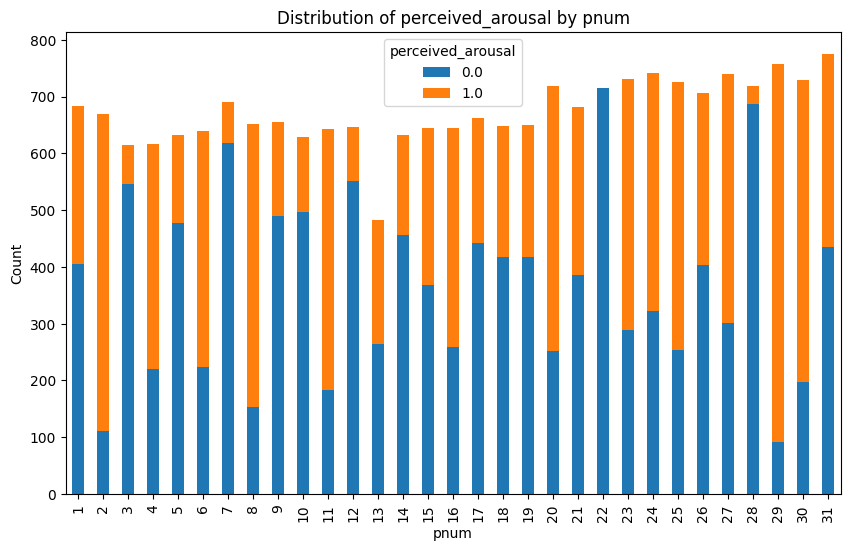

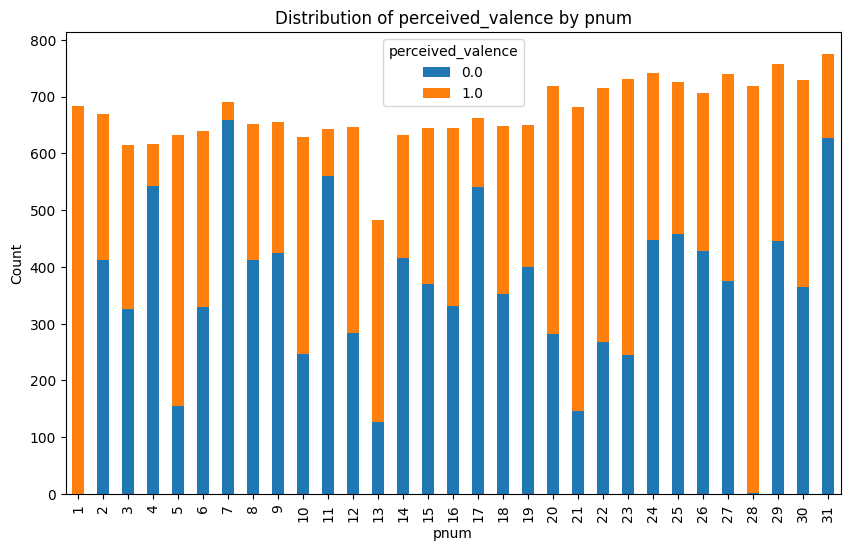

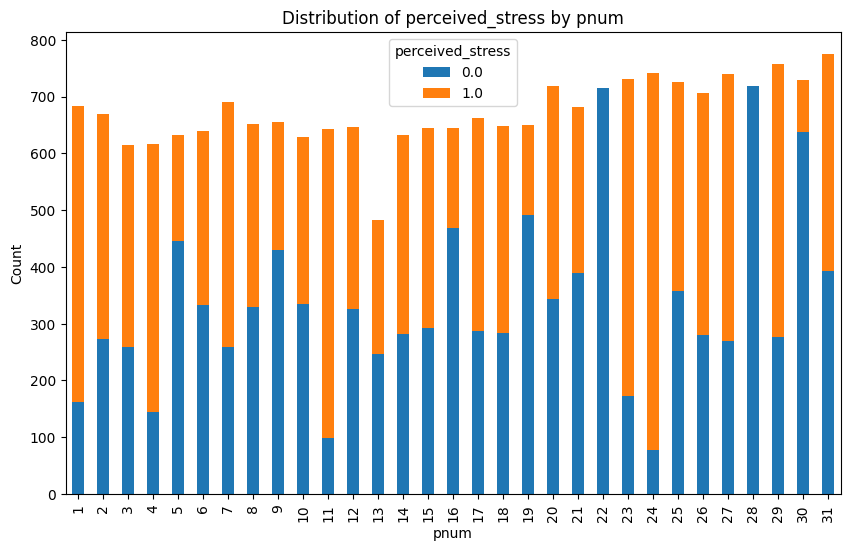

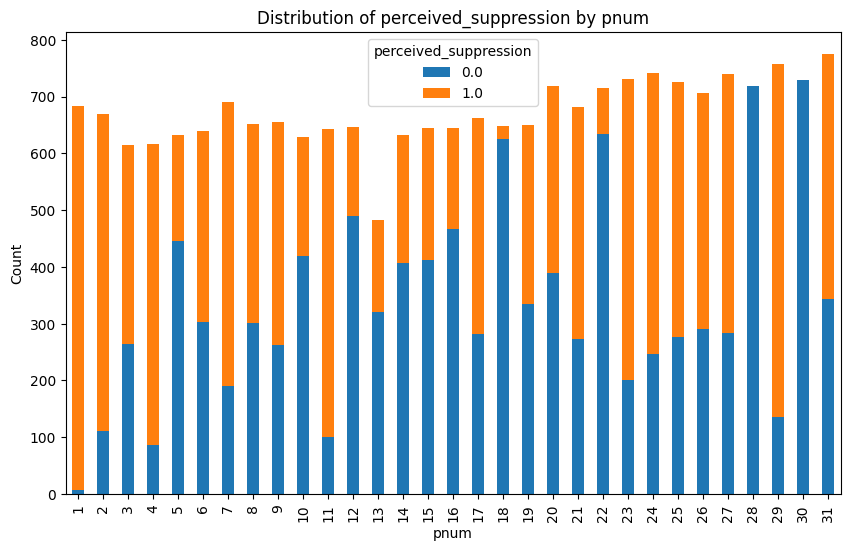

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20875 entries, 0 to 265
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   perceived_arousal      20875 non-null  float64
 1   perceived_valence      20875 non-null  float64
 2   perceived_stress       20875 non-null  float64
 3   perceived_suppression  20875 non-null  float64
 4   pnum                   20875 non-null  int64  
 5   session                20875 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 1.6 MB


In [12]:
# This code is optional. If you want to check the information, you can use this. 
def plot_all_stacked_bar_label_distributions(df):
    label_columns = [col for col in df.columns if col not in ['pnum', 'session']]
    
    for label in label_columns:
        distribution = df.groupby(['pnum', label]).size().unstack(fill_value=0)
        distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(f"Distribution of {label} by pnum")
        plt.xlabel("pnum")
        plt.ylabel("Count")
        plt.legend(title=label)
        plt.show()

plot_all_stacked_bar_label_distributions(encoded_LABEL)
encoded_LABEL.describe()
encoded_LABEL.info()

### - Data integeration 

In [13]:
temp_AUDIO_CUSTOMER = AUDIO_CUSTOMER.drop(columns='Timestamp').reset_index(drop=True)
temp_AUDIO_WORKER = AUDIO_WORKER.drop(columns='Timestamp').reset_index(drop=True)
temp_EDA_MEAN = EDA_MEAN[EDA_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_EDA_PEAK = EDA_PEAK[EDA_PEAK.columns.drop('Timestamp')].reset_index(drop=True)
temp_EEG_MEAN_BANDPOWER = EEG_MEAN_BANDPOWER[EEG_MEAN_BANDPOWER.columns.drop('Timestamp')].reset_index(drop=True)
temp_TEMP_MEAN = TEMP_MEAN[TEMP_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_ACC_MEAN = ACC_MEAN[ACC_MEAN.columns.drop('Timestamp')].reset_index(drop=True)
temp_ECG_HRV = ECG_HRV[ECG_HRV.columns.drop(['Timestamp', 'Datetime'])].reset_index(drop=True)
temp_ECG_HR = ECG_HR[ECG_HR.columns.drop(['Timestamp', 'Datetime'])].reset_index(drop=True)

temp_LABEL = encoded_LABEL[encoded_LABEL.columns].reset_index(drop=True)

result = pd.concat([temp_AUDIO_CUSTOMER, temp_AUDIO_WORKER, temp_EDA_MEAN, temp_EDA_PEAK, temp_EEG_MEAN_BANDPOWER, temp_TEMP_MEAN, temp_ACC_MEAN, temp_ECG_HRV, temp_ECG_HR, temp_LABEL], axis=1)

In [14]:
result_nona = result.dropna().reset_index(drop=True)
print(result.shape) # (20875, 234)
print(result_nona.shape) # (20875, 234)

(20875, 234)
(20875, 234)


## B. Model training and validation

In [15]:
# All refferred to Hide and Seek paper 
MODEL_DICT = {
    "XGBoost": xgb.XGBClassifier(objective='binary:logistic',
                                max_depth=3,
                                learning_rate=0.1,
                                n_estimators=100,
                                eval_metric='mlogloss'),
    "DecisionTree": DecisionTreeClassifier(criterion='entropy', min_samples_split=20), # Referred to WESAD
    "SVM": SVC(probability=True, kernel='rbf', C=107, gamma=0.001), # Referred to Mishra's paper (https://dl.acm.org/doi/pdf/10.1145/3432220)
    "RandomForest":RandomForestClassifier(criterion='gini', min_samples_split=20, n_estimators=100), # Referred to WESAD
    "kNN": KNeighborsClassifier(n_neighbors=9) # Referred to WESAD 
}

In [16]:
Condition = True # False : perceived labels 

if Condition is True:
    columns_to_exclude = ['perceived_stress', 'perceived_arousal','perceived_valence', 'perceived_suppression']
    result_nona_new = result_nona.drop(columns=columns_to_exclude)
    result_nona_new['session'] = result_nona_new['session'].apply(lambda x: 1 if x in [1, 2] else 0)
else:
    result_nona_new = result_nona.copy()

### - Emotional workload binary classification (condition = True)

In [25]:
def run_experiments(df, n_runs=1, output_dir="Results"):
    GT = 'session'  
    final_df = df.copy()
    print(final_df.head())
    print("\n=== Running for GT:", GT, "===")
    results_all_models = {}

    for model_name, model_obj in MODEL_DICT.items():
        print(model_name)
        model_out_dir = os.path.join(output_dir, model_name, GT)
        os.makedirs(model_out_dir, exist_ok=True)
        all_runs_records = []  # List to store all run-test results

        for run_i in range(n_runs):
            X_features = final_df.drop(['pnum', 'session'], axis=1, errors='ignore')
            y_label = final_df['session']

            # Group = pnum
            PIDS = final_df['pnum']
            splitter = LeaveOneGroupOut()
            run_records = []

            for I_train, I_test in splitter.split(X_features, y_label, PIDS):

                X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test]
                y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
                test_name = np.unique(PIDS[I_test])[0]

                if len(np.unique(y_test)) == 1:
                    print(f"Warning: Test set for p{test_name} has only one unique label. Skipping.")
                    continue

                clf_params = model_obj.get_params()
                clf_type = model_obj.__class__
                clf = clf_type(**clf_params)

                # fit
                clf.fit(X_train, y_train)
                # predict
                y_pred = clf.predict(X_test)

                try:
                    y_prob = clf.predict_proba(X_test)
                except:
                    y_prob = None
                    print(model_name, "does not support predict_proba()")
            
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='binary')
                precision_ = precision_score(y_test, y_pred, average='binary')
                recall_ = recall_score(y_test, y_pred, average='binary')

                # AUC
                if y_prob is not None and y_prob.shape[1] == 2:
                    # probabilities of positive class
                    y_prob_pos = y_prob[:, 1]
                    auc_ = roc_auc_score(y_test, y_prob_pos)
                else:
                    auc_ = np.nan

                cm = confusion_matrix(y_test, y_pred)
                result_dict = {
                    'test_name': f"p{test_name}",
                    'accuracy': acc,
                    'f1_score': f1,
                    'precision': precision_,
                    'recall': recall_,
                    'auc': auc_,
                    'confusion_matrix': cm
                }

                run_records.append(result_dict)

            # DataFrame of all test results for this run
            run_records_df = pd.DataFrame(run_records)
            run_records_df['run_i'] = run_i
            all_runs_records.append(run_records_df)

        # Combine all run×test results for each model
        if len(all_runs_records) == 0:
            print(f"No valid results for model={model_name} / GT={GT}. Skipping.")
            continue
        all_df = pd.concat(all_runs_records, ignore_index=True)

        # Save to file (each model / GT separately)
        save_csv_path = os.path.join(model_out_dir, f"all_runs_results.csv")
        all_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')
        print(f"Saved detailed test results -> {save_csv_path}")

        summary_cols = ['accuracy', 'f1_score', 'precision', 'recall', 'auc']

        mean_vals = all_df[summary_cols].mean()
        std_vals = all_df[summary_cols].std()
        summary_df = pd.DataFrame({
            'metric': summary_cols,
            'mean': mean_vals.values,
            'std': std_vals.values
        })
        summary_csv_path = os.path.join(model_out_dir, f"summary_{n_runs}runs.csv")
        summary_df.to_csv(summary_csv_path, index=False, encoding='utf-8-sig')

        # print if needed
        print(f"\n[{model_name}][{GT}] Mean±Std:")
        print(summary_df)

In [ ]:
Root_path = os.path.dirname(os.path.dirname(os.getcwd()))
RESULT_PATH = os.path.join(Root_path,'RESULTS', 'Condition')  
os.makedirs(RESULT_PATH, exist_ok=True)

run_experiments(result_nona_new, n_runs=5, output_dir=RESULT_PATH)

   customer_f0_max  customer_voiced_flag_max  customer_energy_max  customer_zcr_max  customer_cent_max  customer_spec_bw_max  customer_rolloff_max  customer_rolloff_min_max  customer_contrast_max  customer_mfcc_1_max  customer_mfcc_2_max  customer_mfcc_3_max  customer_mfcc_4_max  customer_mfcc_5_max  customer_mfcc_6_max  customer_mfcc_7_max  customer_mfcc_8_max  customer_mfcc_9_max  customer_mfcc_10_max  customer_mfcc_11_max  customer_mfcc_12_max  customer_mfcc_13_max  customer_f0_min  customer_voiced_flag_min  customer_energy_min  customer_zcr_min  customer_cent_min  customer_spec_bw_min  customer_rolloff_min  customer_rolloff_min_min  customer_contrast_min  customer_mfcc_1_min  customer_mfcc_2_min  customer_mfcc_3_min  customer_mfcc_4_min  customer_mfcc_5_min  customer_mfcc_6_min  customer_mfcc_7_min  customer_mfcc_8_min  customer_mfcc_9_min  customer_mfcc_10_min  customer_mfcc_11_min  customer_mfcc_12_min  customer_mfcc_13_min  customer_f0_mean  customer_voiced_flag_mean  customer_e

c:\Users\gyuna\Desktop\Gyuna\projects\K-Emoworker\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\gyuna\Desktop\Gyuna\projects\K-Emoworker\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\gyuna\Desktop\Gyuna\projects\K-Emoworker\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\gyuna\Desktop\Gyuna\projects\K-Emoworker\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\gyuna\Desktop\Gyuna\projects\K-Emoworker\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encode

Saved detailed test results -> c:\Users\gyuna\Desktop\Gyuna\projects\RESULTS\Condition\XGBoost\session\all_runs_results.csv

[XGBoost][session] Mean±Std:
      metric      mean       std
0   accuracy  0.838355  0.162659
1   f1_score  0.870851  0.177951
2  precision  0.858081  0.154607
3     recall  0.915282  0.197240
4        auc  0.902670  0.172229
DecisionTree
Saved detailed test results -> c:\Users\gyuna\Desktop\Gyuna\projects\RESULTS\Condition\DecisionTree\session\all_runs_results.csv

[DecisionTree][session] Mean±Std:
      metric      mean       std
0   accuracy  0.764584  0.143881
1   f1_score  0.811918  0.140178
2  precision  0.834255  0.122081
3     recall  0.821735  0.194048
4        auc  0.746121  0.157478
SVM


### - Perceived labels classifications (condition = False)

In [ ]:
def select_only_gt_label_keep_non_labels(df, gt_label):
    label_columns = [col for col in df.columns if ('perceived' in col)]
    
    if gt_label not in label_columns:
        raise ValueError(f"'{gt_label}' column is not recognized as a label column. Detected label columns: {label_columns}")
    
    # Select all columns that are not labels
    non_label_columns = [col for col in df.columns if col not in label_columns]
    
    # Columns to keep in the end: all columns that are not labels + the selected gt_label
    columns_to_keep = non_label_columns + [gt_label]
    t_df = df[columns_to_keep].copy()
    t_df.rename(columns={gt_label: "label"}, inplace=True)

    return t_df

In [ ]:
def run_experiments_perceived(df, n_runs=1, output_dir="Results"):
    label_list = ['perceived_stress', 'perceived_arousal','perceived_valence', 'perceived_suppression']

    for label in label_list:
        GT = f"{label}"  # e.g.,: "stress_dynamic_binary"
        final_df = select_only_gt_label_keep_non_labels(df, GT)
        print("\n=== Running for GT:", GT, "===")
        results_all_models = {}

        for model_name, model_obj in MODEL_DICT.items():
            model_dir = os.path.join(output_dir, GT, model_name)
            os.makedirs(model_dir, exist_ok=True)
            all_runs_records = []  # List to store all run and test results
            for run_i in range(n_runs):
                X_features = final_df.drop(['pnum', 'session','label'], axis=1, errors='ignore')
                y_label = final_df['label']

                # Group = pnum
                PIDS = final_df['pnum']
                splitter = LeaveOneGroupOut()
                run_records = []

                for I_train, I_test in splitter.split(X_features, y_label, PIDS):
                    X_train, X_test = X_features.iloc[I_train], X_features.iloc[I_test]
                    y_train, y_test = y_label.iloc[I_train], y_label.iloc[I_test]
                    test_name = np.unique(PIDS[I_test])[0]

                    if len(np.unique(y_test)) == 1:
                        print(f"Warning: Test set for p{test_name} has only one unique label. Skipping.")
                        continue

                    clf_params = model_obj.get_params()
                    clf_type = model_obj.__class__
                    clf = clf_type(**clf_params)

                    # fit
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)

                    try:
                        y_prob = clf.predict_proba(X_test)
                    except:
                        y_prob = None
                        print(model_name, "does not support predict_proba()")

                    acc = accuracy_score(y_test, y_pred)
                    f1 = f1_score(y_test, y_pred, average='binary')
                    precision_ = precision_score(y_test, y_pred, average='binary')
                    recall_ = recall_score(y_test, y_pred, average='binary')

                    # AUC
                    if y_prob is not None and y_prob.shape[1] == 2:
                        # probabilities of positive class
                        y_prob_pos = y_prob[:, 1]
                        auc_ = roc_auc_score(y_test, y_prob_pos)
                    else:
                        auc_ = np.nan

                    cm = confusion_matrix(y_test, y_pred)
                    result_dict = {
                        'test_name': f"p{test_name}",
                        'accuracy': acc,
                        'f1_score': f1,
                        'precision': precision_,
                        'recall': recall_,
                        'auc': auc_,
                        'confusion_matrix': cm
                    }

                    run_records.append(result_dict)

                # DataFrame of all test results for this run
                run_records_df = pd.DataFrame(run_records)
                run_records_df['run_i'] = run_i
                all_runs_records.append(run_records_df)

            # Combine all run×test results (by model)
            if len(all_runs_records) == 0:
                print(f"No valid results for model={model_name} / GT={GT}. Skipping.")
                continue
            all_df = pd.concat(all_runs_records, ignore_index=True)

            # Save to file (each model / GT separately)
            save_csv_path = os.path.join(model_dir, f"all_runs_results.csv")
            all_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')
            print(f"Saved detailed test results -> {save_csv_path}")

            summary_cols = ['accuracy', 'f1_score', 'precision', 'recall', 'auc']

            mean_vals = all_df[summary_cols].mean()
            std_vals = all_df[summary_cols].std()
            summary_df = pd.DataFrame({
                'metric': summary_cols,
                'mean': mean_vals.values,
                'std': std_vals.values
            })
            summary_csv_path = os.path.join(model_dir, f"summary_{n_runs}runs.csv")
            summary_df.to_csv(summary_csv_path, index=False, encoding='utf-8-sig')

            # If necessary, print
            print(f"\n[{model_name}][{GT}] Mean±Std:")
            print(summary_df)

print("\n=== Done! ===")

In [ ]:
Root_path = os.path.dirname(os.path.dirname(os.getcwd()))
RESULT_PATH = os.path.join(Root_path,'RESULTS', 'Perceived')  
os.makedirs(RESULT_PATH, exist_ok=True)

run_experiments_perceived(result_nona_new, n_runs=5, output_dir=RESULT_PATH)

## C. Results visualization

In [ ]:
models   = ["RandomForest", "XGBoost", "SVM" ,"kNN", "DecisionTree"]]
metrics  = ["accuracy","auc", "f1_score", "precision","recall", ]  

root = os.path.join(Root_path,'RESULTS')
base_dir = os.path.join(root, 'Condition')

In [ ]:
# Table results summary 

In [ ]:
summary_rows = []
for m in models:
    f = os.path.join(base_dir, m, "session", "summary_5runs.csv")
    sdf = pd.read_csv(f)                       # columns: metric, mean, std
    flat = {}                                   # ex) {"accuracy_mean":0.91, "accuracy_std":0.02, ...}
    for _, r in sdf.iterrows():
        metric = r["metric"]
        flat[f"{metric}_mean"] = r["mean"]
        flat[f"{metric}_std"]  = r["std"]
    summary_rows.append(pd.Series(flat, name=m))

summary_df = pd.concat(summary_rows, axis=1).T   # Rows: model, Columns: metric

print("\n[Combined summary]\n", summary_df)

In [ ]:
# histogram of all results 

In [ ]:
# First, calculate the individual mean/std for all models
person_stats = {m: {} for m in models}   # {model: {metric: (mean Series, std Series)}}
for m in models:
    f = os.path.join(base_dir, m, "session", "all_runs_results.csv")
    rdf = pd.read_csv(f)                                 # include run_i
    for met in metrics:
        grp = rdf.groupby("test_name")[met]
        person_stats[m][met] = (grp.mean(), grp.std())

for m in models:
    means = person_stats[m]["auc"][0]           # Series(index=test_name, values=mean)
    stds  = person_stats[m]["auc"][1]
    order = means.sort_values().index           # low -> high
    means_ord = means.reindex(order)
    stds_ord  = stds.reindex(order)

    fig, ax = plt.subplots(figsize=(8, 4), dpi=300)
    x = np.arange(len(order))
    ax.bar(x, means_ord, yerr=stds_ord, capsize=3)
    #ax.set_xticks([]) 
    ax.set_xticks(x)
    ax.set_xticklabels(order, rotation=90, fontsize=8)                         # hide PID; use order if needed
    ax.set_ylabel("AUC")
    ax.set_title(f"{m} – AUC per person (mean ± std)")
    plt.tight_layout()
    #plt.savefig(f"fig_auc_persons_{m}.png")
    plt.show()        
